# Classifying NBA Player Positions by K-Means Clustering

In this notebook, I will attempt to utilise the K-Means Clustering unsupervised machine learning algorithm to classify NBA players into their correct positions.

Historically, there have been five player positions on an NBA court. These are:
-Point Guard (PG)
-Shooting Guard (SG)
-Small Forward (SF)
-Power Forward (PF)
-Center (C)

Typically these positions range from smallest (PG) to tallest (C), however there has been a modern trend towards 'positionless basketball' and 'small ball' teams that defy old norms of player sizes. (https://en.wikipedia.org/wiki/Small_ball_(basketball))

I will attempt to classify players into their positions as listed on ESPN.com using a K-Means Clustering algorithm to see if players can still be accurately described using a position in the modern NBA.

## Step 1: Scrape the Data

Data will be scraped from ESPN.com using BeautifulSoup - a Python library built for web scraping.

In [54]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
df = pd.read_csv('nba_player_data_2020.csv')

In [22]:
df.head()

,Team,No.,Player,Pos,Ht,Wt,Birth Date,Country,Exp,College
0,MIL,11,Brook Lopez,C,7-0,282,"April 1, 1988",us,12,Stanford
1,MIL,9,Wesley Matthews,SG,6-4,220,"October 14, 1986",us,11,Marquette
2,MIL,24,Pat Connaughton,SG,6-5,209,"January 6, 1993",us,5,Notre Dame
3,MIL,0,Donte DiVincenzo,SG,6-4,203,"January 31, 1997",us,2,Villanova
4,MIL,42,Robin Lopez,C,7-0,281,"April 1, 1988",us,12,Stanford


Upon first glance, the height column ('Ht') does not look numerical - lets explore this.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Team        510 non-null    object
 1   No.         489 non-null    object
 2   Player      510 non-null    object
 3   Pos         510 non-null    object
 4   Ht          510 non-null    object
 5   Wt          510 non-null    int64 
 6   Birth Date  510 non-null    object
 7   Country     510 non-null    object
 8   Exp         510 non-null    object
 9   College     435 non-null    object
dtypes: int64(1), object(9)
memory usage: 40.0+ KB


We can see here that the height column is indeed stored as an object, rather than an integer. To fix this I will create a new column named 'Height' that is the players height in inches.

In [42]:
df.iloc[0]['Ht']

'7-0'

The height of Brook Lopez shows us that the height is stored as a string, whereby feet and inches are separated by a '-'.

In [51]:
def feet_to_inches(Ht):
    return (int(Ht.split('-')[0]) * 12) + int(Ht.split('-')[1])

In [52]:
df['Height_Inches'] = df.apply(lambda row: feet_to_inches(row['Ht']),axis=1)

In [53]:
df.head()

,Team,No.,Player,Pos,Ht,Wt,Birth Date,Country,Exp,College,Height_Inches
0,MIL,11,Brook Lopez,C,7-0,282,"April 1, 1988",us,12,Stanford,84
1,MIL,9,Wesley Matthews,SG,6-4,220,"October 14, 1986",us,11,Marquette,76
2,MIL,24,Pat Connaughton,SG,6-5,209,"January 6, 1993",us,5,Notre Dame,77
3,MIL,0,Donte DiVincenzo,SG,6-4,203,"January 31, 1997",us,2,Villanova,76
4,MIL,42,Robin Lopez,C,7-0,281,"April 1, 1988",us,12,Stanford,84


The Height_Inches column now lists players height in inches as an integer.

The relationship between height and weight is plotted below.

Text(0.5, 0, 'Height in Inches')

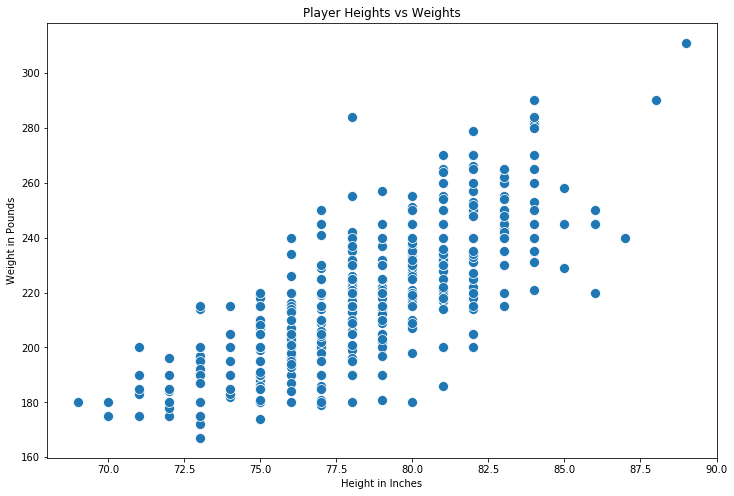

In [160]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Height_Inches',y='Wt',data=df,s=100)
plt.title('Player Heights vs Weights')
plt.ylabel('Weight in Pounds')
plt.xlabel('Height in Inches')

As one would expect, the general trend is that the taller a player is, the heavier they are.

The next step is to investigate the positions listed in the data.

In [60]:
df['Pos'].unique()

array(['C', 'SG', 'PF', 'SF', 'PG', 'G', 'F', 'F-G', 'G-F', 'F-C'],
      dtype=object)

In [61]:
print('There are ' + str(len(df['Pos'].unique())) + ' positions listed in the data')

There are 10 positions listed in the data


Whilst there are five positions on a basketball court, the ability for a player to play in multiple positions means that combinations of positions are listed in the dataset. 

This may be useful for players seeking to play positionless basketball, but it is not useful for this data - since we want to separate players into the five main positions.

To fix this issue, any player with multiple positions listed (e.g. G-F or F-C) will be designated by the following rules:
- 'G-F' becomes 'SG'
- 'F-G' becomes 'SF'
- 'F-C' becomes 'PF'

This fixes the issue of 'F-G', 'G-F' and 'F-C'. However it does not fix those listed as just 'G' or 'F' without a specific position.

In [68]:
df['Pos'].replace({'G-F': 'SG', 'F-G': 'SF', 'F-C': 'PF'},inplace=True)

In [69]:
df['Pos'].value_counts()

SG    132
PF    101
C      92
SF     86
PG     84
F       8
G       7
Name: Pos, dtype: int64

Now there remain 8 players listed as 'F' and 7 players listed as 'G'. These players will be removed from the dataframe to avoid me placing them into their positions arbitrarily.

In [70]:
df = df[(df['Pos'] != 'F') & (df['Pos'] != 'G')]

In [71]:
df['Pos'].value_counts()

SG    132
PF    101
C      92
SF     86
PG     84
Name: Pos, dtype: int64

Now the scatterplot of height vs weight can be plotted once again, and the individual datapoints highlighted by which position they belong to.

Text(0, 0.5, 'Wight in Pounds')

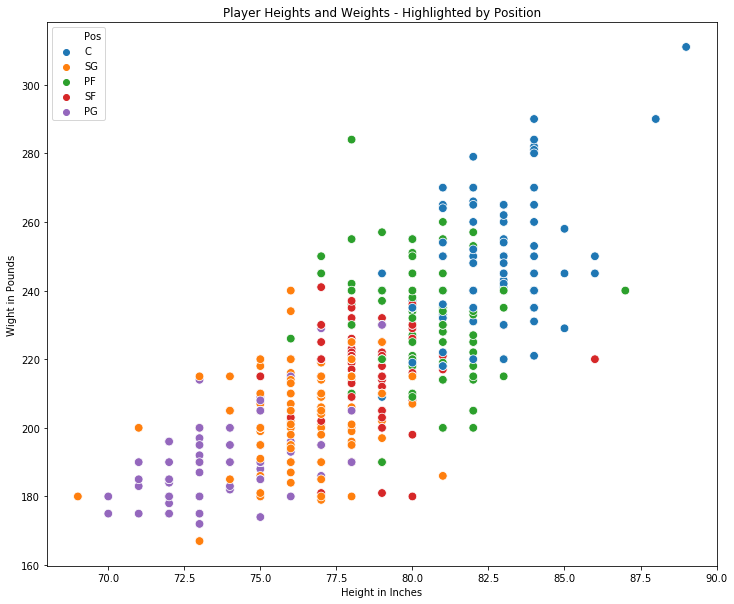

In [161]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='Height_Inches',y='Wt',data=df,hue='Pos',s=75)
plt.title('Player Heights and Weights - Highlighted by Position')
plt.xlabel('Height in Inches')
plt.ylabel('Wight in Pounds')

As the scatterplot above shows, generally as players height and weight go up their position changes; from PG to SG to SF to PF to C. However there does seem to be a bit of noise in the data, there are no clear lines separating the positions which may prove to be a problem for the clustering algorithm.

# K-Means Cluster Algorithm Creation

The question is, can a K-Means Clustering algorithm accurately predict the position of a player?

In [77]:
# Import the model from sklearn
from sklearn.cluster import KMeans

In [78]:
#Create an instance of a model with 5 clusters
kmeans = KMeans(n_clusters=5)

In [93]:
#Fit the model to the height and weight data
kmeans.fit(df[['Height_Inches','Wt']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [95]:
#Adding the kmeans labels as a column to the df
df['kmeans-label'] = pd.Series(kmeans.labels_, index=df.index)

C:\Users\Michael\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [96]:
df.head()

,Team,No.,Player,Pos,Ht,Wt,Birth Date,Country,Exp,College,Height_Inches,kmeans-label
0,MIL,11,Brook Lopez,C,7-0,282,"April 1, 1988",us,12,Stanford,84,2
1,MIL,9,Wesley Matthews,SG,6-4,220,"October 14, 1986",us,11,Marquette,76,1
2,MIL,24,Pat Connaughton,SG,6-5,209,"January 6, 1993",us,5,Notre Dame,77,3
3,MIL,0,Donte DiVincenzo,SG,6-4,203,"January 31, 1997",us,2,Villanova,76,3
4,MIL,42,Robin Lopez,C,7-0,281,"April 1, 1988",us,12,Stanford,84,2


Text(0.5, 1.0, 'Original Data')

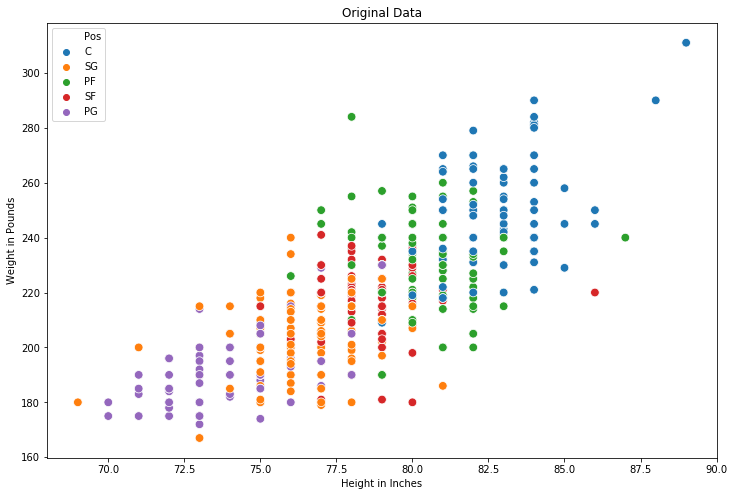

In [163]:
#Plotting player heights and weights, and coloring the points based on their position.
plt.figure(figsize=(12,8))
sns.scatterplot(x='Height_Inches',y='Wt',data=df,hue='Pos',s=75)
plt.xlabel('Height in Inches')
plt.ylabel('Weight in Pounds')
plt.title('Original Data')

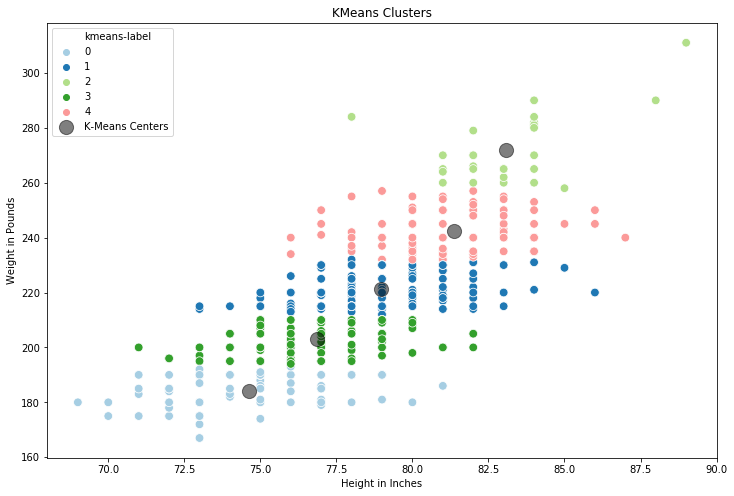

In [164]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Height_Inches',y='Wt',data=df,hue='kmeans-label',palette='Paired',s=75)
plt.xlabel('Height in Inches')
plt.ylabel('Weight in Pounds')
plt.title('KMeans Clusters')
centers = kmeans.cluster_centers_
plot_centers = plt.scatter(centers[:,0],centers[:,1],c='black',s=200,alpha=0.5,label='K-Means Centers')
plt.legend()

By observing and comparing the two scatterplots, some differences can be noted.

The clustering algorithm provides clear cutoff lines at certain weights for each position, whereas the real position data is much more fluid. Perhaps there are more physical traits which influence a players position such as their wingspan or vertical jump height. 

More likely is the fact that players positions are determined by their skillsets as much as they are by their phycsical attributes; possibly including shooting percentages and assist/turnover ratio statistics for each player could improve the algorithm.

In [129]:
centers = kmeans.cluster_centers_
centers

array([[ 74.64285714, 184.28571429],
       [ 78.9527027 , 221.11486486],
       [ 83.07407407, 271.88888889],
       [ 76.84920635, 203.07936508],
       [ 81.36363636, 242.51818182]])

The center of each cluster that the algorithm has determined is provided in the array above. These cluster centers can be mapped to positions in the dataset based on the position they most likely are trying to describe based on the average height/weight of a player in that position.

In [140]:
height_weight_means = df.groupby('Pos')[['Height_Inches','Wt']].mean()
height_weight_means

,Height_Inches,Wt
Pos,,
C,82.608696,248.076087
PF,80.445545,230.445545
PG,74.226190,192.702381
SF,78.755814,216.895349
SG,76.500000,203.583333


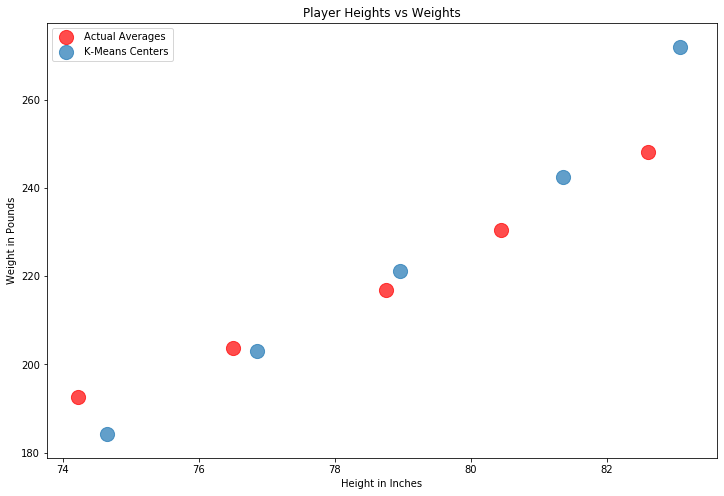

In [165]:
plt.figure(figsize=(12,8))
plt.scatter(x=height_weight_means['Height_Inches'],y=height_weight_means['Wt'],c='red',label='Actual Averages',s=200,alpha=0.7)
plt.scatter(x=[i[0] for i in centers],y=[i[1] for i in centers],label='K-Means Centers',s=200,alpha=0.7)
plt.ylabel('Weight in Pounds')
plt.xlabel('Height in Inches')
plt.title('Player Heights vs Weights')
plt.legend()

I will create a function that labels the players actual position based on the numbering mechanism derived by the algorithm. This will allow a comparison between the players real position and the position that the algorithm predicted they would play.

These are:
- PG = 0
- SG = 3
- SF = 1
- PF = 4
- C = 2

In [101]:
# Creating a function that labels the positions in the dataset akin to the number the kmeans algorithm uses.
def position_to_num(pos):
    if pos == 'PG':
        return 0
    elif pos == 'SG':
        return 3
    elif pos == 'SF':
        return 1
    elif pos == 'PF':
        return 4
    else:
        return 2

In [102]:
df['Pos-label'] = df.apply(lambda x: position_to_num(x['Pos']),axis=1)

C:\Users\Michael\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
df.head()

,Team,No.,Player,Pos,Ht,Wt,Birth Date,Country,Exp,College,Height_Inches,kmeans-label,Pos-label
0,MIL,11,Brook Lopez,C,7-0,282,"April 1, 1988",us,12,Stanford,84,2,2
1,MIL,9,Wesley Matthews,SG,6-4,220,"October 14, 1986",us,11,Marquette,76,1,3
2,MIL,24,Pat Connaughton,SG,6-5,209,"January 6, 1993",us,5,Notre Dame,77,3,3
3,MIL,0,Donte DiVincenzo,SG,6-4,203,"January 31, 1997",us,2,Villanova,76,3,3
4,MIL,42,Robin Lopez,C,7-0,281,"April 1, 1988",us,12,Stanford,84,2,2


In [106]:
from sklearn.metrics import classification_report

In [127]:
print(classification_report(df['Pos-label'],kmeans.labels_))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        84
           1       0.36      0.63      0.46        86
           2       0.89      0.26      0.40        92
           3       0.51      0.48      0.49       132
           4       0.40      0.44      0.42       101

    accuracy                           0.47       495
   macro avg       0.55      0.48      0.47       495
weighted avg       0.54      0.47      0.47       495



The classification report shows that the position which was most accurately predicted using the clustering algorithm was Center (position number 2), which has an 89% precision.

The position which was predicted with the second highest level of accuracy was Poing Guard (position number 0), with a 58% precision.

These positions had the highest precision because they are the tallest and smallest positions on the court respectfully. These tend to be very specialist positions for a big player and a little player, which lends itself to being predicted using this algorithm.

The positions in-between these two are difficult for the algorithm to predict, which may be evidence of the modern trend towards positionless basketball as mentioned previously.

This research could be expanded by quantifying the trend towards positionless basketball my utilising the same clustering algorithm on player data from a season 10 or 20 years ago, where I believe the algorithm would have much more accuracy in predicting player positions for shooting guards, small forwards, and power forwards.

Overall, the K-Means clustering algorithm was only able to predict 55% of players positions correctly when using their heights and weights. Whilst I believe including some more data may improve the model, I don;t think it will ever be as accurate as it may be on some previous seasons data due to the trend towards positionless basketball.